# Bibliotheek

Installeer OpenCV:

    https://pypi.org/project/opencv-python/
    
Plotten van foto's: 

    https://matplotlib.org/stable/tutorials/introductory/images.html
    
Installeer scikit-image: 
    
    https://scikit-image.org/docs/stable/install.html
    
scikit-images voorbeelden:

    https://scikit-image.org/docs/stable/auto_examples/index.html

In [8]:
import skimage
import cv2

import matplotlib.pyplot as plt
import numpy as np

# Continue beeld

In [37]:
import cv2
def list_available_cameras(max_cameras=5):
    available = []
    for idx in range(max_cameras):
        cap = cv2.VideoCapture(idx)
        if cap.isOpened():
            available.append(idx)
            cap.release()
    print("Beschikbare camera's:", available)

list_available_cameras()
camera = cv2.VideoCapture(0)  # Maak verbinding met camera ID 1

# Stel een vaste belichtingstijd in (indien ondersteund)
camera.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0)  # Auto-exposure uit (driver-afhankelijk)
camera.set(cv2.CAP_PROP_EXPOSURE, -1)
camera.set(cv2.CAP_PROP_AUTO_WB, 0)         # Handmatige belichting (waarde afhankelijk van driver)

while True:
    retval, frame = camera.read()
    if not retval:
        break

    # Toon live beeld in een venster
    cv2.imshow("Live feed", frame)

    # Stoppen als je op 'q' drukt
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()


Beschikbare camera's: [0, 1, 2]


# Foto voorbeeld

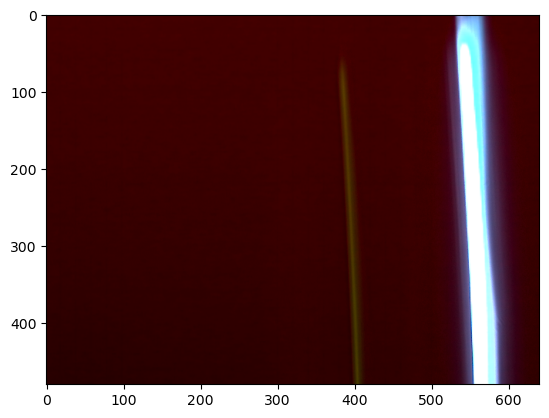

In [39]:
camera = cv2.VideoCapture(0) # Maak verbinding met int : camera id

camera.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25)  # Auto-exposure uit (driver-afhankelijk)
camera.set(cv2.CAP_PROP_EXPOSURE, -2)       # Handmatige belichting (waarde afhankelijk van driver)

retval, frame = camera.read() # lees de camera uit

plt.imshow(frame) # geef het uitgelezen frame weer

camera.release() # verbreek de verbinding met de camera

# Camera instellingen

# Voorbeeld beeld analyse

RGB -> Grayscale: 

https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_rgb_to_gray.html#sphx-glr-auto-examples-color-exposure-plot-rgb-to-gray-py

Matplotlib colormaps:

https://matplotlib.org/stable/tutorials/colors/colormaps.html

## RGB -> Zwart wit
We hebben slechts interesse in de (relatieve) intensiteit van pixels. Wegens deze reden zetten we het beeld van kleur om naar zwart wit.

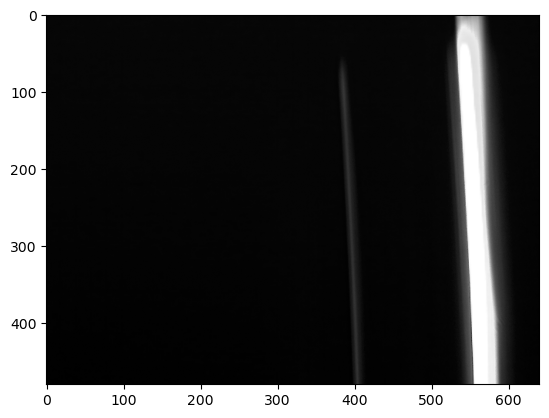

In [40]:
grayscale = skimage.color.rgb2gray(frame) # RGB -> grayscale

plt.imshow(grayscale, cmap=plt.cm.gray) # De colormap (cmap) is puur ter visuele weergave

In [41]:
print("RGB ndarray shape: ", frame.shape) # 3 kanaals
print("Grayscale ndarray shape: ", grayscale.shape) # 1 kanaals

RGB ndarray shape:  (480, 640, 3)
Grayscale ndarray shape:  (480, 640)


## Intensiteit per pixel kolom
We kunnen alle waarden van één kolom sommeren om de z.g. intensiteit van de betreffende kolom te bepalen. Deze intensiteit heeft (nog) geen eenheid, daarom noemen we dit `arbitrary units` (a.u.). 

Wanneer het lichtspectrum over de CMOS verspreid is zou je onderstaande code kunnen gebruiken om (bijna) direct een spectrogram te krijgen. Het pixel nummer is namenlijk te koppelen aan spatiële informatie en daarmee aan de frequentie van het licht.

Text(0, 0.5, 'intensity [a.u.]')

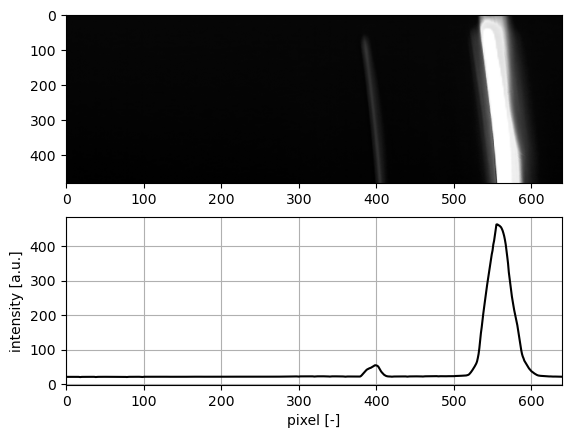

In [42]:
I = grayscale.sum(axis=0) # row wise summation


plt.subplot(2,1,1)
plt.imshow(grayscale, cmap=plt.cm.gray, aspect="auto")
xmin, xmax = plt.xlim() # grab min max values from imshow

plt.subplot(2,1,2)
plt.plot(I, c='black')

plt.xlim(xmin,xmax) # set min max values

plt.grid()
plt.xlabel(r"pixel [-]")
plt.ylabel(r"intensity [a.u.]")

# Intensiteit per frame
Het zal voorkomen dat we geinteresseerd zijn in de relatieve intensiteit van het algehele camera beeld. Dit is op verschillende manieren te bepalen. Men kan de pixel intensiteit van het gehele frame bij elkaar optellen. Daar zou je nog de achtergrond ruis (`shot noise`) vanaf kunnen halen. Echter, als dat overal aanwezig is dan is dit voor het simpelste doeleinde van het spectroscoop practicum niet relevant. We bekijken toch slechts relatieve informatie.

## Intensiteit van één frame

In [43]:
I_frame = grayscale.sum() # sommatie van één frame
I_frame

np.float64(31488.917012941176)

In [46]:
import numpy as np
from scipy.signal import find_peaks
# x en y zijn numpy arrays
x = np.arange(I.size)  # pixel indices
y = I                  # intensity values

peaks, _ = find_peaks(y, height=40)
peak_x = x[peaks]
peak_y = y[peaks]
print("Gevonden pieken:")
for xi, yi in zip(peak_x, peak_y):
    print(xi, yi)

Gevonden pieken:
399 55.31586039215688
556 462.56689450980406


Fit parameters: [1.32787482e-01 5.16177365e+02]
Parameter unzekerheden: [0.00182786 0.73528883]


Text(0, 0.5, 'Golflengte (nm)')

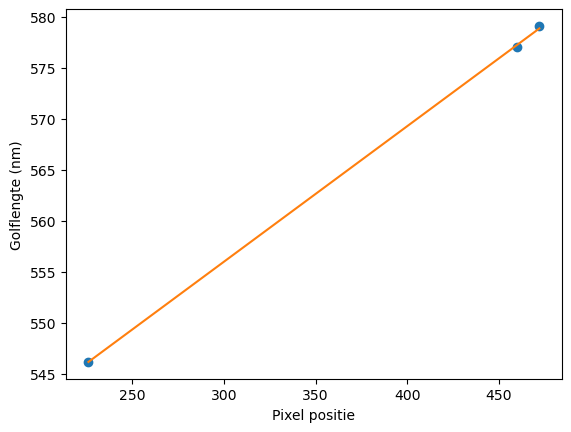

In [33]:
from scipy.optimize import curve_fit

def fitfunc(x,a,b):
    return a*x + b

x_pixels = peak_x
y_golflengte = np.array([546.2,577.0,579.1]) # nm

popt, pcov = curve_fit(fitfunc, peak_x, y_golflengte)
fit_y = fitfunc(x_pixels, *popt)

perr = np.sqrt(np.diag(pcov))
print("Fit parameters:" , popt)
print("Parameter unzekerheden:", perr)

plt.plot(x_pixels, y_golflengte, 'o', label='Data punten')
plt.plot(x_pixels, fit_y, '-', label='Lineaire fit')
plt.xlabel('Pixel positie')
plt.ylabel('Golflengte (nm)')

[569.1595706  590.00720526]


Text(0, 0.5, 'Golflengte (nm)')

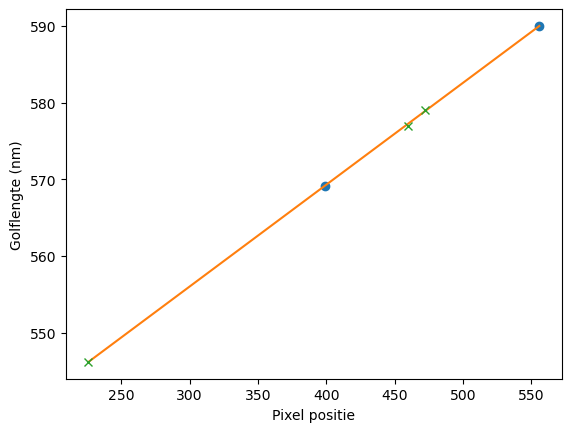

In [60]:
a = popt[0]
b = popt[1]

x_pixel = peak_x
new_x = np.append(x_pixels, 556)


golflengte = fitfunc(x_pixel, a, b)
print(golflengte)

plt.plot(x_pixel, golflengte, 'o')
plt.plot(new_x, fitfunc(new_x, a, b), '-')
plt.plot(x_pixels, y_golflengte, 'x')
plt.xlabel('Pixel positie')
plt.ylabel('Golflengte (nm)')



In [62]:
fout_labda = np.sqrt( (perr[0]*x_pixel)**2 + perr[1]**2 )
print(perr[0])
print(perr[1])
print(fout_labda)

0.0018278554297043348
0.7352888311417526
[1.03563943 1.25438837]
